In [ ]:
#Generative Adversarial network

'''
Goal : To autonomously identify patterns in input data, enabling model to produce new examples that feasibly resemble the original dataset

GAN is made up of two neural network
1. Discriminator
2. Generator

GAN are broken down into 3 parts :
Generative : To learn a generative model which describes how data is generated in terms of a probabilistic model
Adversarial : Here generative result is compared with actual images in the data set.
Network : Use deep neural network as AI algo for training purpose

Generator model :
The generator takes random noise as input and converts it into complex data samples
Generator loss :
The objective of the generator is to produce synthetic samples that are realistic enough to fool the discriminator
We can achieve this by minimizing its loss function.
'''

'\nGoal : To autonomously identify patterns in input data, enabling model to produce new examples that feasibly resemble the original dataset\n\nGAN is made up of two neural network\n1. Discriminator\n2. Generator\n\nGAN are broken down into 3 parts :\nGenerative : To learn a generative model which describes how data is generated in terms of a probabilistic model\nAdversarial : Here generative result is compared with actual images in the data set.\nNetwork : Use deep neural network as AI algo for training purpose\n\nGenerator model :\nThe generator takes random noise as input and converts it into complex data samples\nGenerator loss :\nThe objective of the generator is to produce synthetic samples that are realistic enough to fool the discriminator\nWe can achieve this by minimizing its loss function.\n'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#Setting up a device
'''
Setting up a device in PyTorch involves specifying whether your computations should be performed on a CPU or a GPU.
PyTorch allows you to easily switch between these devices, which is crucial for taking advantage of GPU.
CUDA - (Compute Unified Device Architecture) It allows us to use the power of GPU for the training purpose
'''

'\nSetting up a device in PyTorch involves specifying whether your computations should be performed on a CPU or a GPU.\nPyTorch allows you to easily switch between these devices, which is crucial for taking advantage of GPU.\nCUDA - (Compute Unified Device Architecture) It allows us to use the power of GPU for the training purpose\n'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Converting images to tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
'''
transforms.ToTensor() -> #Convert PIL or numpy array into pytorch tensor and  It converts the image's pixel values to floating-point values between 0 and 1 and
reorders the dimensions to (C, H, W), where C is the number of channels (e.g., 3 for RGB images), H is the height, and W is the width.

transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) -> This transformation normalizes the tensor by subtracting the mean and dividing by the standard deviation along each channel.
The mean and std arguments are tuples representing the mean and standard deviation values for each channel in the image.
(0.5,0.5,0.5) -> mean for each channel
(0.5,0.5,0.5) -> std for each channel
'''

"\ntransforms.ToTensor() -> #Convert PIL or numpy array into pytorch tensor and  It converts the image's pixel values to floating-point values between 0 and 1 and\nreorders the dimensions to (C, H, W), where C is the number of channels (e.g., 3 for RGB images), H is the height, and W is the width.\n\ntransforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) -> This transformation normalizes the tensor by subtracting the mean and dividing by the standard deviation along each channel.\nThe mean and std arguments are tuples representing the mean and standard deviation values for each channel in the image.\n(0.5,0.5,0.5) -> mean for each channel\n(0.5,0.5,0.5) -> std for each channel\n"

In [7]:
#Loading dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
'''
root='./data': This specifies the directory where the dataset will be downloaded (if it's not already available) and stored.
train=True: This indicates that the dataset is intended for training. If set to False, it would create a dataset for testing or validation.
download=True: This specifies that the dataset should be downloaded if it's not already available in the specified root directory.
transform=transform: This parameter applies transformations to the dataset. In your case, transform is a Compose object that contains a series of transformations,
including converting the images to tensors and normalizing them
'''

100%|██████████| 170498071/170498071 [00:03<00:00, 43704684.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


"\nroot='./data': This specifies the directory where the dataset will be downloaded (if it's not already available) and stored.\ntrain=True: This indicates that the dataset is intended for training. If set to False, it would create a dataset for testing or validation.\ndownload=True: This specifies that the dataset should be downloaded if it's not already available in the specified root directory.\ntransform=transform: This parameter applies transformations to the dataset. In your case, transform is a Compose object that contains a series of transformations,\nincluding converting the images to tensors and normalizing them\n"

In [8]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
#To create batches for training purpose

In [9]:
'''
Parameter for GAN
Latent space (input noise vector) dimensionality -> size of the input noise vector that serves as the input to the generator network

Learning rate

coefficients for ADAM optimizer beta1 and beta2 ->
In the Adam optimizer, the parameters beta1 and beta2 are coefficients used for computing exponential moving averages of gradients (beta1) and squared gradients (beta2), respectively.
These moving averages are used to adaptively adjust the learning rate for each parameter during training.

'''

latent_dim = 100
lr  = 0.0002
beta1 = 0.5
'''
Higher values of beta1 (closer to 1.0) can help stabilize the optimization process by providing smoother updates to the parameter estimates.
However, setting it too close to 1.0 might slow down convergence.
'''
beta2 = 0.999
'''
Higher values of beta2 (closer to 1.0) allow the optimizer to adapt more quickly to changes in gradient magnitudes.
However, excessively high values might lead to erratic behavior, especially in the presence of noisy gradients.
'''
num_epochs = 10

In [10]:
class Generator(nn.Module):
  #We are subclassing the nn.module class

  def __init__(self, latent_dim):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128 * 8 * 8),
        nn.ReLU(),
        nn.Unflatten(1, (128,8,8)),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128, momentum=0.78),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64, momentum=0.78),
        nn.ReLU(),
        nn.Conv2d(64, 3, kernel_size=3, padding=1),
        nn.Tanh()
        )

  def forward(self, z):
    img = self.model(z)
    return img





In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
        )

  def forward(self, img):
    validity = self.model(img)
    return validity

In [12]:
#Buliding the network

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [13]:
#Loss function
adversarial_loss = nn.BCELoss()

In [14]:
#Optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1,beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1,beta2))

Epoch [1/10]Batch100/1563Discriminator Loss : 0.4998Generator Loss : 1.2098
Epoch [1/10]Batch200/1563Discriminator Loss : 0.6141Generator Loss : 0.9088
Epoch [1/10]Batch300/1563Discriminator Loss : 0.6013Generator Loss : 1.0729
Epoch [1/10]Batch400/1563Discriminator Loss : 0.6918Generator Loss : 0.9175
Epoch [1/10]Batch500/1563Discriminator Loss : 0.4478Generator Loss : 1.5701
Epoch [1/10]Batch600/1563Discriminator Loss : 0.4745Generator Loss : 1.2849
Epoch [1/10]Batch700/1563Discriminator Loss : 0.5501Generator Loss : 1.1237
Epoch [1/10]Batch800/1563Discriminator Loss : 0.7630Generator Loss : 0.8266
Epoch [1/10]Batch900/1563Discriminator Loss : 0.6770Generator Loss : 0.9381
Epoch [1/10]Batch1000/1563Discriminator Loss : 0.6054Generator Loss : 1.0143
Epoch [1/10]Batch1100/1563Discriminator Loss : 0.6558Generator Loss : 0.8931
Epoch [1/10]Batch1200/1563Discriminator Loss : 0.6923Generator Loss : 0.6646
Epoch [1/10]Batch1300/1563Discriminator Loss : 0.7298Generator Loss : 0.8296
Epoch [1

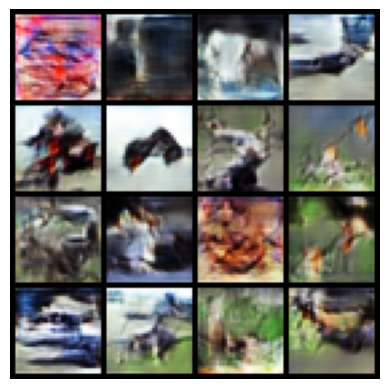

In [ ]:
#Training

for epoch in range(num_epochs):
  for i, batch in enumerate(dataloader):
    real_images = batch[0].to(device)

    valid = torch.ones(real_images.size(0), 1, device=device)
    fake = torch.zeros(real_images.size(0), 1, device=device)

    real_images = real_images.to(device)

    #Training discriminator

    optimizer_D.zero_grad()

    #Giving imput noise
    z = torch.randn(real_images.size(0), latent_dim, device=device)

    #Generating batch of images
    fake_images = generator(z)


    #Measuring discriminators ability
    real_loss = adversarial_loss(discriminator(real_images), valid)
    fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)

    d_loss = (real_loss + fake_loss) / 2

    #Backward pass and optimize
    d_loss.backward()
    optimizer_D.step()

    #Training generator
    optimizer_G.zero_grad()
    #Generating batch of images
    gen_images = generator(z)

    #adversarial loss
    g_loss = adversarial_loss(discriminator(gen_images), valid)

    g_loss.backward()
    optimizer_G.step()


    #Monitoring progress
    if (i + 1) % 100 == 0:
      print(
          f"Epoch [{epoch + 1}/{num_epochs}]Batch{i + 1}/{len(dataloader)}"
          f"Discriminator Loss : {d_loss.item():.4f}"
          f"Generator Loss : {g_loss.item():.4f}"
      )

  if (epoch + 1) % 10 ==0:
    with torch.no_grad():
      z = torch.randn(16, latent_dim, device=device)
      generated = generator(z).detach().cpu()
      grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)

      plt.imshow(np.transpose(grid, (1, 2, 0)))
      plt.axis("off")
      plt.show()



In [15]:
torch.save(Generator, 'generator_model.pth')
torch.save(Discriminator, 'discriminator_model.pth')

In [16]:
import torch
import torchvision.models as models

In [19]:
generator = torch.load('generator_model.pth')
generator.eval()

TypeError: Module.eval() missing 1 required positional argument: 'self'